In [5]:
# Imports
import pandas as pd
import numpy as np
import scipy.stats as stats
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
plt.rcParams['figure.dpi'] = 300

# * = things to maybe simplify

----

### Importing data

In [6]:
# Import gene lists
Asterias = []
with open("Data/Genelists/Asterias.rubens.genelist.bed") as f:
    for line in f:
        Asterias.append(line.strip().split())

Adata = pd.DataFrame(Asterias, 
                     columns = ['Chromosome', 'Start', 'End', 'Name', 'Dot'])
 
Holothuria = []
with open("Data//Genelists/Holothuria.leucospilota.genelist.bed") as f:
    for line in f:
        Holothuria.append(line.strip().split())

Hdata = pd.DataFrame(Holothuria, 
                     columns = ['Chromosome', 'Start', 'End', 'Name', 'Dot'])

Paracentrotus = []
with open("Data//Genelists/Paracentrotus.lividus.genelist.bed") as f:
    for line in f:
        Paracentrotus.append(line.strip().split())

Pdata = pd.DataFrame(Paracentrotus, 
                     columns = ['Chromosome', 'Start', 'End', 'Name', 'Dot'])

# Import orthologs
AH_orthodata = np.loadtxt("Data/Orthologs/Asterias.rubens+Holothuria.leucospilota.txt", dtype = "str")

AP_orthodata = np.loadtxt("Data/Orthologs/Asterias.rubens+Paracentrotus.lividus.txt", dtype = "str")
AP_orthodata = pd.DataFrame(AP_orthodata, columns = ['Code', 'A', 'P'])

HP_orthodata = np.loadtxt("Data/Orthologs/Holothuria.leucospilota+Paracentrotus.lividus.txt", dtype = "str")

#### Data cleaning

In [7]:
# AP orthologies: remove prefixes on gene names
AP_orthodata['P'] = AP_orthodata['P'].str.removeprefix('Parliv_')
AP_orthodata = AP_orthodata.to_numpy()

# Asterias data: removing non-chromosome values
val1 = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 
        'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 
        'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 
        'chr19', 'chr20', 'chr21', 'chr22', 'chr23']

Adata = Adata.loc[Adata['Chromosome'].isin(val1)]

# Paracentrotus data: Calculate number of genes on each scaffold
Portho = Pdata.groupby('Chromosome').size()
Portho = Portho.reset_index()

Portho.columns = ['Chromosome', 'Count']
Portho = Portho.loc[Portho['Count'] >= 100]

scaffolds = Portho.Chromosome.tolist() # Remove all values from non-chromosome scaffolds
Pdata = Pdata.loc[Pdata['Chromosome'].isin(scaffolds)]

____

#### Make ortholog dictionaries

In [8]:
# AH
A_AH_orthdict = dict(zip(AH_orthodata[:, 1], AH_orthodata[:, 0]))
H_AH_orthdict = dict(zip(AH_orthodata[:, 2], AH_orthodata[:, 0]))

# AP
A_AP_orthdict = dict(zip(AP_orthodata[:, 1], AP_orthodata[:, 0]))
P_AP_orthdict = dict(zip(AP_orthodata[:, 2], AP_orthodata[:, 0]))

# HP
H_HP_orthdict = dict(zip(HP_orthodata[:, 1], HP_orthodata[:, 0]))
P_HP_orthdict = dict(zip(HP_orthodata[:, 2], HP_orthodata[:, 0]))

#### Replace values with ortholog dictionary

In [9]:
# AH
A_AH_data = Adata.replace({"Name": A_AH_orthdict})
H_AH_data = Hdata.replace({"Name" : H_AH_orthdict})

# AP
P_AP_data = Pdata.replace({'Name': P_AP_orthdict})
A_AP_data = Adata.replace({'Name': A_AP_orthdict})

# HP
H_HP_data = Hdata.replace({"Name": H_HP_orthdict})
P_HP_data = Pdata.replace({"Name": P_HP_orthdict})

Add a column for orthologs, 1 if ortholog, 0 if not

In [10]:
# AH
H_AH_data["Ortholog"] = H_AH_data["Name"].apply(lambda x:1 if 'ortholog' in x.lower() else 0)
A_AH_data["Ortholog"] = A_AH_data["Name"].apply(lambda x:1 if 'ortholog' in x.lower() else 0)

# AP
P_AP_data["Ortholog"] = P_AP_data["Name"].apply(lambda x:1 if 'ortholog' in x.lower() else 0)
A_AP_data["Ortholog"] = A_AP_data["Name"].apply(lambda x:1 if 'ortholog' in x.lower() else 0)

# HP
H_HP_data["Ortholog"] = H_HP_data["Name"].apply(lambda x:1 if 'ortholog' in x.lower() else 0)
P_HP_data["Ortholog"] = P_HP_data["Name"].apply(lambda x:1 if 'ortholog' in x.lower() else 0)

#### Isolate orthologies

In [11]:
# AH
H_AH_ortho = H_AH_data.loc[H_AH_data["Ortholog"] == 1]
H_AH_dict = dict(zip(H_AH_data.loc[H_AH_data["Ortholog"] == 1].Name, H_AH_data.loc[H_AH_data["Ortholog"] == 1].Chromosome))

A_AH_ortho = A_AH_data.loc[A_AH_data['Ortholog'] == 1]
A_AH_dict = dict(zip(A_AH_ortho.Name, A_AH_ortho.Chromosome))

# AP
P_AP_ortho = P_AP_data.loc[P_AP_data['Ortholog'] == 1]
P_AP_dict = dict(zip(P_AP_ortho.Name, P_AP_ortho.Chromosome))

A_AP_ortho = A_AP_data.loc[A_AP_data['Ortholog'] == 1]
A_AP_dict = dict(zip(A_AP_ortho.Name, A_AP_ortho.Chromosome))

# HP
H_HP_ortho = H_HP_data.loc[H_HP_data['Ortholog'] == 1]
H_HP_dict = dict(zip(H_HP_ortho.Name, H_HP_ortho.Chromosome))

P_HP_ortho = P_HP_data.loc[P_HP_data['Ortholog'] == 1]
P_HP_dict = dict(zip(P_HP_ortho.Name, P_HP_ortho.Chromosome))


Seperating all orthology entries into new dataframes:
Ortholog | Location in A | Location in H

In [12]:
# AH
AH_Odata = pd.DataFrame({'Orthologs' : AH_orthodata[:, 0],
                        'A' : AH_orthodata[:, 0],
                        'H' : AH_orthodata[:, 0]})

# Replace location in A and H with orthology dictionary keys
AH_Odata['A'] = AH_Odata['A'].map(A_AH_dict)
AH_Odata['H'] = AH_Odata['H'].map(H_AH_dict)

# Calculate number of orthologs for each pair of chromosomes
AH_Odata = AH_Odata.groupby(['A', 'H']).count().reset_index()

In [13]:
# AP
AP_Odata = pd.DataFrame({'Orthologs' : AP_orthodata[:, 0],
                        'A' : AP_orthodata[:, 0],
                        'P' : AP_orthodata[:, 0]})

# Replace location in A and H with orthology dictionary keys
AP_Odata['A'] = AP_Odata['A'].map(A_AP_dict)
AP_Odata['P'] = AP_Odata['P'].map(P_AP_dict)

# Calculate number of orthologs for each pair of chromosomes
AP_Odata = AP_Odata.groupby(['A', 'P']).count().reset_index()

In [14]:
# HP
HP_Odata = pd.DataFrame({'Orthologs' : HP_orthodata[:, 0],
                        'H' : HP_orthodata[:, 0],
                        'P' : HP_orthodata[:, 0]})

# Replace location in A and H with orthology dictionary keys
HP_Odata['H'] = HP_Odata['H'].map(H_HP_dict)
HP_Odata['P'] = HP_Odata['P'].map(P_HP_dict)

# Calculate number of orthologs for each pair of chromosomes
HP_Odata = HP_Odata.groupby(['H', 'P']).count().reset_index()

----

### Hypergeometric testing
M: total number of orthologs in the dataset

nA, nB: number of orthologs on AchrN and BchrN individually

x: number of orthologs on both AchrN and BchrN

In [15]:
def hypertest(chrA, chrB, dataset, speciesA, speciesB, speciesAortho, speciesBortho):
    """
    inputs:
    chrA: species A chromosome name 
    chrB: species B chromosome name
    speciesA: column name in dataset for species A
    speciesB: column name in dataset for species B
    speciesAortho: orthology data for species A
    speciesBortho: orthology data for species B
    """
    
    M = len(list(set(A_AH_data.Name.values.tolist()) & set(H_AH_data.Name.values.tolist())))
    
    nA = dataset.loc[(dataset[speciesA] == chrA), 'Orthologs'].sum()
    nB = dataset.loc[(dataset[speciesB] == chrB), 'Orthologs'].sum()
    x = dataset.loc[(dataset[speciesA] == chrA) & (dataset[speciesB] == chrB), 'Orthologs'].sum()
    
    p = stats.hypergeom.sf(x - 1, M, nA, nB)
     
    return p

Applying hypergeometric testing function

In [16]:
# AH
AH_Odata['p'] = AH_Odata.apply(lambda x: hypertest(x['A'], x['H'], dataset = AH_Odata, 
                                                   speciesA = 'A', speciesB = 'H',
                                                   speciesAortho = 'A_AH_data', speciesBortho = 'H_AH_data'), axis = 1)

# Apply BH testing correction
AH_Odata['result'], AH_Odata['p'] = pg.multicomp(AH_Odata['p'], method = 'fdr_bh') 

# Remove all rows that have been rejected in BH correction
AH_cOdata = AH_Odata.loc[AH_Odata["result"] == True]

In [17]:
# AP
AP_Odata['p'] = AP_Odata.apply(lambda x: hypertest(x['A'], x['P'], dataset = AP_Odata, 
                                                   speciesA = 'A', speciesB = 'P',
                                                   speciesAortho = 'A_AP_data', speciesBortho = 'P_AP_data'), axis = 1)

# Apply BH testing correction
AP_Odata['result'], AP_Odata['p'] = pg.multicomp(AP_Odata['p'], method = 'fdr_bh') 

# Remove all rows that have been rejected in BH correction
AP_cOdata = AP_Odata.loc[AP_Odata["result"] == True]

In [18]:
# HP
HP_Odata['p'] = HP_Odata.apply(lambda x: hypertest(x['H'], x['P'], dataset = HP_Odata, 
                                                   speciesA = 'H', speciesB = 'P',
                                                   speciesAortho = 'H_HP_data', speciesBortho = 'P_HP_data'), axis = 1)

# Apply BH testing correction
HP_Odata['result'], HP_Odata['p'] = pg.multicomp(HP_Odata['p'], method = 'fdr_bh') 

# Remove all rows that have been rejected in BH correction
HP_cOdata = HP_Odata.loc[HP_Odata["result"] == True]

HP_cOdata

,H,P,Orthologs,p,result
13,Hchr1,Scaffold_3433,177,1.150710e-131,True
20,Hchr10,Scaffold_174,165,1.468176e-105,True
46,Hchr11,Scaffold_3429,243,0.000000e+00,True
61,Hchr12,Scaffold_3426,179,5.673585e-178,True
90,Hchr13,Scaffold_674,289,0.000000e+00,True
96,Hchr14,Scaffold_3425,403,0.000000e+00,True
117,Hchr15,Scaffold_3428,380,0.000000e+00,True
128,Hchr16,Scaffold_218,314,0.000000e+00,True
155,Hchr17,Scaffold_3432,406,0.000000e+00,True
177,Hchr18,Scaffold_641,280,0.000000e+00,True


-----

#### Dotplots

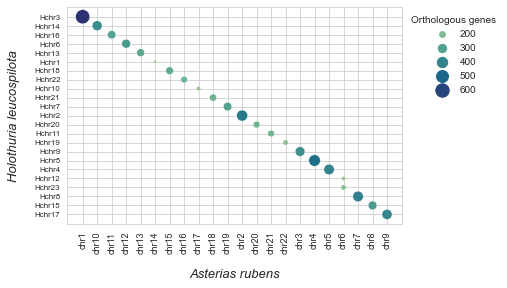

In [19]:
# AH
plt.rcParams['figure.figsize'] = [8, 8]
sns.set_style("whitegrid")
sns.scatterplot(data = AH_cOdata, x = 'A', y = 'H', 
                size = 'Orthologs', sizes = (10, 200),
                hue = 'Orthologs', palette = "crest")

plt.xlabel("Asterias rubens", fontsize = 13, 
           labelpad = 15, style = 'italic')
plt.ylabel("Holothuria leucospilota", fontsize = 13, 
           labelpad = 15, style = 'italic')

plt.xticks(rotation='vertical', fontsize = 9)
plt.yticks(fontsize = 8)

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', 
           fontsize=10, title = 'Orthologous genes', frameon = False)

plt.show()

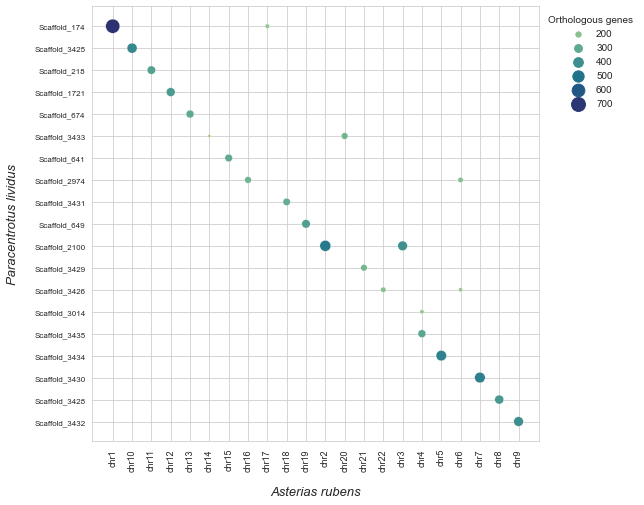

In [20]:
# AP
plt.rcParams['figure.figsize'] = [8, 8]
sns.set_style("whitegrid")
sns.scatterplot(data = AP_cOdata, x = 'A', y = 'P', 
                size = 'Orthologs', sizes = (10, 200),
                hue = 'Orthologs', palette = "crest")

plt.xlabel("Asterias rubens", fontsize = 13, 
           labelpad = 15, style = 'italic')
plt.ylabel("Paracentrotus lividus", fontsize = 13, 
           labelpad = 15, style = 'italic')

plt.xticks(rotation='vertical', fontsize = 9)
plt.yticks(fontsize = 8)

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', 
           fontsize=10, title = 'Orthologous genes', frameon = False)

plt.show()

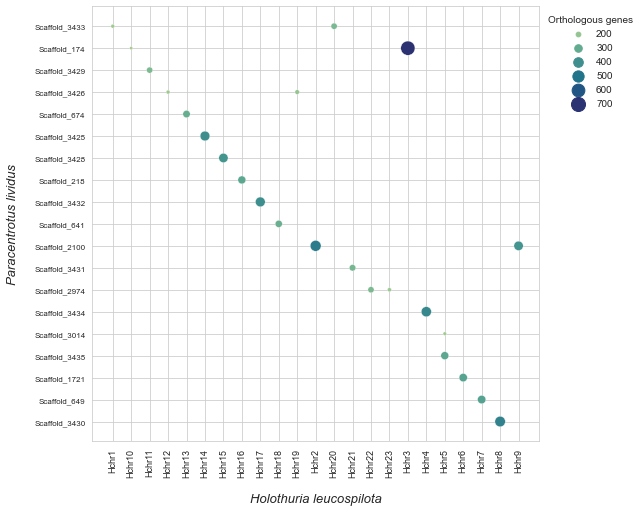

In [21]:
# HP
plt.rcParams['figure.figsize'] = [8, 8]
sns.set_style("whitegrid")
sns.scatterplot(data = HP_cOdata, x = 'H', y = 'P', 
                size = 'Orthologs', sizes = (10, 200),
                hue = 'Orthologs', palette = "crest")

plt.xlabel("Holothuria leucospilota", fontsize = 13, 
           labelpad = 15, style = 'italic')
plt.ylabel("Paracentrotus lividus", fontsize = 13, 
           labelpad = 15, style = 'italic')

plt.xticks(rotation='vertical', fontsize = 9)
plt.yticks(fontsize = 8)

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', 
           fontsize=10, title = 'Orthologous genes', frameon = False)

plt.show()

----

In [22]:
iloc[:, 3]

NameError: name 'iloc' is not defined

In [ ]:
def orthofy(genelistA, genelistB, orthologies):
    
    """
    inputs:
    genelistA: gene list for species A
    genelistB: gene list for species B
    orthologies: orthology dataset
    """
    
    # Make ortholog dictionaries
    A_orthdict = dict(zip(orthologies[:, 1], orthologies[:, 0]))
    B_orthdict = dict(zip(orthologies[:, 2], orthologies[:, 0]))

    # Replace genelist values with ortholog dictionaries
    A_data = genelistA.replace({'Name': A_orthdict})
    B_data = genelistB.replace({'Name' : B_orthdict})
    
    # Add column for orthologs: 1 if ortholog, 0 if not
    B_data['Ortholog'] = B_data['Name'].apply(lambda x:1 if 'ortholog' in x.lower() else 0)
    A_data['Ortholog'] = A_data['Name'].apply(lambda x:1 if 'ortholog' in x.lower() else 0)
    
    # Isolate orthologies
    A_ortho = A_data.loc[A_data['Ortholog'] == 1]
    A_dict = dict(zip(A_ortho.Name, A_ortho.Chromosome))

    B_ortho = B_data.loc[B_data['Ortholog'] == 1]
    B_dict = dict(zip(B_ortho.Name, B_ortho.Chromosome))
    
    # Seperate all orthology entries into new dataframe
    AB_data = pd.DataFrame({'Orthologs' : orthologies[:, 0],
                            'speciesA' : orthologies[:, 0],
                            'speciesB' : orthologies[:, 0]})
    
    # Replace location in A and B with orthology dictionary keys
    AB_data['speciesA'] = AB_data['speciesB'].map(A_dict)
    AB_data['speciesB'] = AB_data['speciesB'].map(B_dict)
    
    # Calculate number of orthologs for each pair of chromosomes
    AB_data = AB_data.groupby(['speciesA', 'speciesB']).count().reset_index()
    
    A = A_data.Name.values.tolist()
    B = B_data.Name.values.tolist()
    M = len(list(set(A) & set(B)))
    
    # Define inner function for hypergeometric testing
    def hypertest(chrA, chrB):
        nA = AB_data.loc[(AB_data['speciesA'] == chrA), 'Orthologs'].sum()
        nB = AB_data.loc[(AB_data['speciesB'] == chrB), 'Orthologs'].sum()
        x = AB_data.loc[(AB_data['speciesA'] == chrA) & (AB_data['speciesB'] == chrB), 'Orthologs'].sum()
    
        p = stats.hypergeom.sf(x - 1, M, nA, nB)
        
        return p

    # Conduct hypergeometric testing
    AB_data['p-Values'] = AB_data.apply(lambda x : hypertest(x['speciesA'], x['speciesB']), axis = 1)
    
    # Apply BH testing correction
    AB_data['Results'], AB_data['p-Values'] = pg.multicomp(AB_data['p-Values'], method = 'fdr_bh')
    
    # Remove all rows that have been rejected in BH correction
    AB_data = AB_data.loc[AB_data['Results'] == True]
    
    return AB_data

In [ ]:
orthofy(Adata, Hdata, AH_orthodata)

,speciesA,speciesB,Orthologs,p-Values,Results
15,chr1,Hchr3,658,0.000000e+00,True
25,chr10,Hchr14,372,0.000000e+00,True
50,chr11,Hchr16,294,0.000000e+00,True
79,chr12,Hchr6,322,0.000000e+00,True
85,chr13,Hchr13,274,0.000000e+00,True
102,chr14,Hchr1,132,9.564365e-190,True
127,chr15,Hchr18,267,0.000000e+00,True
152,chr16,Hchr22,227,0.000000e+00,True
161,chr17,Hchr10,157,4.320883e-258,True
193,chr18,Hchr21,244,0.000000e+00,True
